In [1]:
import numpy as np 
import pandas as pd 
import os
import gc
import time
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
train = pd.read_csv('../input/digit-recognizer/train.csv')
test = pd.read_csv('../input/digit-recognizer/test.csv')

In [3]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
train['label'].value_counts() / len(train)

1    0.111524
7    0.104786
3    0.103595
9    0.099714
2    0.099452
6    0.098500
0    0.098381
4    0.096952
8    0.096738
5    0.090357
Name: label, dtype: float64

## split train_data

In [5]:
x_train,x_valid,y_train,y_valid = train_test_split(train.iloc[:,1:],train.iloc[:,0],train_size=0.8,stratify=train.iloc[:,0])

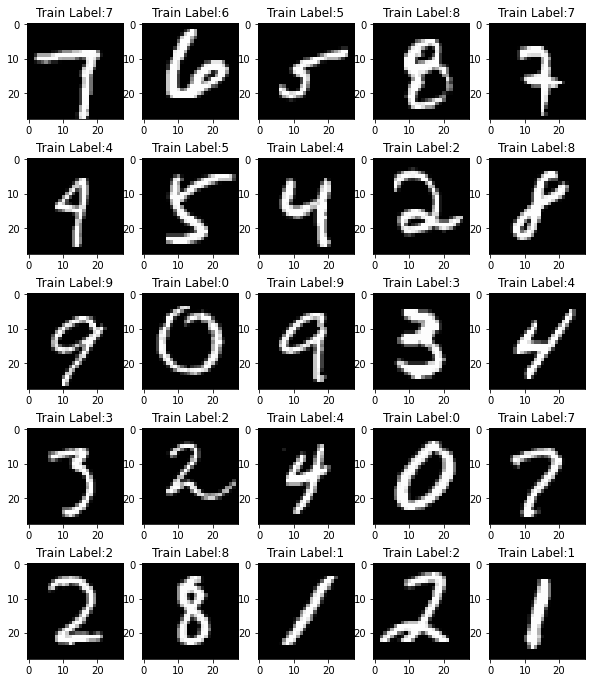

In [6]:
# size = 1 * 784 -> 28*28
train_view = x_train.copy()
train_view = train_view.values.reshape(-1, 28, 28, 1)

fig, ax = plt.subplots(ncols=5, nrows=5, figsize=(10,12))

for index in range(25):
    
    plt.subplot(5, 5, index+1)
    plt.imshow(train_view[index], cmap='gray')
    plt.title('Train Label:'+str(y_train.iloc[index]))
plt.show()

In [7]:
class Loaderdata(Dataset):
    
    def __init__(self,data,labels, mode='rnn'):
        
        super().__init__()
        
        assert data.shape[0] == labels.shape[0],"Feature and label data have different lengths"
        
        if mode == 'rnn':
            
            self.feature = torch.from_numpy((np.array(data)/255.0).reshape(-1, 28, 28)).float()
            self.label = torch.from_numpy(np.array(labels))
        else:
            self.feature = torch.from_numpy((np.array(data)/255.0).reshape(-1, 1, 28, 28)).float()
            self.label = torch.from_numpy(np.array(labels))
        
    def __len__(self):
        
        return len(self.label)
    
    def __getitem__(self,idx):
         
        df = self.feature[idx]
        label_df = self.label[idx]
  
        return df, label_df

In [8]:
traindata = DataLoader(Loaderdata(x_train,y_train),batch_size=64,shuffle=True)  
validdata = DataLoader(Loaderdata(x_valid,y_valid),batch_size=64,shuffle=False)
rnn_testdata = test.values.reshape(-1, 28, 28)
cnn_testdata =  test.values.reshape(-1, 1, 28, 28)

In [9]:
class Rnnmodel(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        
        """
        input_size: dim -> 28
        hidden_size: dim -> 64
        num_layers: 2
        batch_first: True 
        nonlinearity: tanh
        """
        self.rnn1 = nn.RNN(input_size=28, hidden_size=150, batch_first=True, nonlinearity='tanh')
        
        self.liner1 = nn.Linear(in_features=150, out_features=10)
        
    def forward(self, x):
        
        """
        out shape: [-1, 28, 150] -> [batch_size:64, seq_len, hidden_size]
        
        h_t shape: [1, -1, 64] -> [num_layers, batch_size, hidden_size]
        
        out[:, -1, :]  = h_t[-1, :, :]
        """
        out, h_t = self.rnn1(x)  
        out = self.liner1(h_t) 
        out = out.view(-1, 10) # out-> (batch_size, output_size)
        
        return out
        

In [10]:
images_example, labels_example = next(iter(traindata))
print('original images shape:', images_example.shape)
print('labels shape:', labels_example.shape, '\n')

model_example = Rnnmodel()
out = model_example(images_example)

original images shape: torch.Size([64, 28, 28])
labels shape: torch.Size([64]) 



In [11]:
print('Len parameters:', len(list(model_example.parameters())), '\n' +
      'Parameters 0 - U:', list(model_example.parameters())[0].shape, '\n' +
      'Parameters 1 - W:', list(model_example.parameters())[1].shape, '\n' +
      'Parameters 2 - Bias:', list(model_example.parameters())[2].shape, '\n' +
      'Parameters 3 - Bias:', list(model_example.parameters())[3].shape, '\n' +
      'Parameters 4 - FNN weights:', list(model_example.parameters())[4].shape, '\n' +
      'Parameters 5 - Predictions:', list(model_example.parameters())[5].shape)

Len parameters: 6 
Parameters 0 - U: torch.Size([150, 28]) 
Parameters 1 - W: torch.Size([150, 150]) 
Parameters 2 - Bias: torch.Size([150]) 
Parameters 3 - Bias: torch.Size([150]) 
Parameters 4 - FNN weights: torch.Size([10, 150]) 
Parameters 5 - Predictions: torch.Size([10])


In [12]:
class CNNmodel(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        
        """
        C：1
        W：28
        H：28
        """
        
        #(-1, 1, 28, 28)->(-1, 12, 14, 14)
        self.conv1 = nn.Sequential(nn.Conv2d(1,12,kernel_size=3,stride=1, padding=1),
                                 nn.BatchNorm2d(12),
                                 nn.ReLU(),
                                 nn.MaxPool2d(kernel_size=2)) 
        
        #(-1, 12, 14, 14) -> (-1, 24, 7, 7)
        self.conv2 = nn.Sequential(nn.Conv2d(12,24,kernel_size=3,stride=1, padding=1),
                                 nn.BatchNorm2d(24),
                                 nn.ReLU(),
                                 nn.MaxPool2d(kernel_size=2)) 
        
        self.line = nn.Sequential(nn.Linear(24*7*7,250),
                                  nn.BatchNorm1d(250),
                                  nn.ReLU(),
                                  nn.Dropout(0.25),
                                  nn.Linear(250,125),
                                  nn.BatchNorm1d(125),
                                  nn.ReLU(),
                                  nn.Dropout(0.25),
                                  nn.Linear(125,25),
                                  nn.Linear(25,10))
        
    def forward(self,inputs):
        
        out = self.conv1(inputs)
        out = self.conv2(out)
        out = self.line(out.view(-1,24*7*7))
        
        return out

In [13]:
print(Rnnmodel())

Rnnmodel(
  (rnn1): RNN(28, 150, batch_first=True)
  (liner1): Linear(in_features=150, out_features=10, bias=True)
)


In [14]:
print(CNNmodel())

CNNmodel(
  (conv1): Sequential(
    (0): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (line): Sequential(
    (0): Linear(in_features=1176, out_features=250, bias=True)
    (1): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=250, out_features=125, bias=True)
    (5): BatchNorm1d(125, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): D

In [15]:
def train_model(train_, valid_, mode='rnn'):
    
    if mode == 'rnn':
        
        model = Rnnmodel()
    
    else:
        
        model = CNNmodel()
    
    epochs = 10
    
    loss = nn.CrossEntropyLoss() 
    optim = torch.optim.Adam(model.parameters(),lr=0.001) 
    
    #loading labels and preds 
    labels = torch.LongTensor()
    pred = torch.LongTensor()
    
    for epoch in tqdm(range(epochs)):
        
        train_loss = 0.0
        valid_loss = 0.0
        train_acc = 0.0
        valid_acc = 0.0
        
        model.train()
        loop = tqdm(enumerate(train_), total=len(train_))
        
        for idx, (feature,label) in loop:

            outs = model(feature)
            optim.zero_grad()
            train_los = loss(outs, label.long())
            train_los.backward()
            optim.step()
            
            predicted = nn.Softmax(dim=1)(outs)
            predicted = predicted.max(1)[1] 

            acc_total = (predicted == label).sum().item()
            samples = label.shape[0]
            running_acc = float(acc_total) / float(samples)

            loop.set_description(f'Train epoch {epoch+1} / {epochs}')
            loop.set_postfix(loss=train_los.item(), acc=round(running_acc,3))
            
        model.eval()
        loop_valid = tqdm(enumerate(valid_), total=len(valid_))
        for vidx,(feature,label) in loop_valid:
            
            outs = model(feature)

            predicted = nn.Softmax(dim=1)(outs)
            predicted = predicted.max(1)[1]

            acc_total = (predicted == label).sum().item()
            samples = label.shape[0]
            running_acc = float(acc_total) / float(samples)
            
            labels = torch.cat((labels, label), dim=0)
            pred = torch.cat((pred, predicted), dim=0)

            loop_valid.set_description(f'Valid epoch {epoch+1} / {epochs}')
            loop_valid.set_postfix(acc=round(running_acc,3))
    
    tqdm.write('Valid Classification : ')
    tqdm.write(classification_report(labels.numpy(), pred.numpy()))
        
    return model
        

In [16]:
rnn_model = train_model(traindata, validdata)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/525 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/525 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/525 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/525 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/525 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/525 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/525 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/525 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/525 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/525 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

Valid Classification : 
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      8270
           1       0.95      0.97      0.96      9370
           2       0.94      0.93      0.93      8350
           3       0.92      0.92      0.92      8700
           4       0.92      0.93      0.92      8140
           5       0.89      0.85      0.87      7590
           6       0.93      0.96      0.94      8270
           7       0.93      0.95      0.94      8800
           8       0.91      0.90      0.91      8130
           9       0.91      0.88      0.89      8380

    accuracy                           0.93     84000
   macro avg       0.93      0.92      0.92     84000
weighted avg       0.93      0.93      0.93     84000



In [17]:
cnn_traindata = DataLoader(Loaderdata(x_train,y_train, mode='cnn'),batch_size=64,shuffle=True)  
cnn_validdata = DataLoader(Loaderdata(x_valid,y_valid, mode='cnn'),batch_size=64,shuffle=False)
cnn_model = train_model(cnn_traindata, cnn_validdata, mode='cnn')

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/525 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/525 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/525 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/525 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/525 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/525 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/525 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/525 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/525 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/525 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

Valid Classification : 
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      8270
           1       1.00      0.99      0.99      9370
           2       0.98      0.98      0.98      8350
           3       0.99      0.99      0.99      8700
           4       0.99      0.99      0.99      8140
           5       0.99      0.99      0.99      7590
           6       0.99      0.99      0.99      8270
           7       0.98      0.99      0.99      8800
           8       0.98      0.98      0.98      8130
           9       0.98      0.98      0.98      8380

    accuracy                           0.99     84000
   macro avg       0.99      0.99      0.99     84000
weighted avg       0.99      0.99      0.99     84000



In [18]:
with torch.no_grad():
    
    rnn_model.eval()
    cnn_model.eval()
    rnn_pre = rnn_model(torch.Tensor(rnn_testdata))
    cnn_pre = cnn_model(torch.Tensor(cnn_testdata))
    
    predicted = nn.Softmax(dim=1)(rnn_pre+cnn_pre)
    sub_predicted = predicted.max(1)[1]
    
    sub = pd.read_csv('../input/digit-recognizer/sample_submission.csv')
    sub['Label'] = sub_predicted
    sub.to_csv("submission.csv", index=False)
    
    print('End!')

End!
